# Create UV-Vis Dataset for E3NN Machine Learning

### Download Modules

In [1]:
%%capture
!pip install PubChemPy

In [145]:
import pandas as pd
import numpy as np
import io
import sys

from openbabel import pybel

# Import modules
import nglview as nv
import ase.io
import matplotlib.pyplot as plt
import rdkit

# Load psi4 to compute orbitals
import psi4


### Download UV-Vis data

In [1]:
! wget https://raw.githubusercontent.com/PNNL-CompBio/ML_UVvisModels/main/Data/UV_w_SMILES.csv

--2024-07-02 04:08:38--  https://raw.githubusercontent.com/PNNL-CompBio/ML_UVvisModels/main/Data/UV_w_SMILES.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.110.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3442000 (3.3M) [text/plain]
Saving to: ‘UV_w_SMILES.csv.1’

UV_w_SMILES.csv.1   100%[===================>]   3.28M  --.-KB/s    in 0.04s   

2024-07-02 04:08:38 (82.4 MB/s) - ‘UV_w_SMILES.csv.1’ saved [3442000/3442000]



### Load data in Pandas

In [146]:
import pandas as pd

In [147]:
# Define the file path to the CSV file containing UV-Vis data with SMILES strings
uvvis_file = "UV_w_SMILES.csv"

# Read the CSV file into a pandas DataFrame
uvvis_data = pd.read_csv(uvvis_file,header=None)

# Display the contents of the DataFrame
uvvis_data

,0,1,2,3,4,5,6,7,8,9,...,172,173,174,175,176,177,178,179,180,181
0,NC1=NC2=C(C=CC=C2)[N+]([O-])=N1,0.299539,0.311787,0.328491,0.349915,0.376548,0.408694,0.446354,0.489792,0.537421,...,0.092434,0.095006,0.097484,0.099952,0.102239,0.104428,0.106597,0.108721,0.110758,0.112611
1,NC1=NC2=C(C=CC=C2)N=N1,0.411922,0.447550,0.487158,0.530422,0.576958,0.626523,0.678088,0.731087,0.783621,...,0.094415,0.095031,0.095445,0.095832,0.095950,0.095919,0.095820,0.095594,0.095204,0.094772
2,CCC1=[N+]([O-])C2=C(C=CC=C2)[N+]([O-])=N1,0.732482,0.794217,0.853497,0.907398,0.952023,0.983787,1.000000,0.998714,0.982111,...,0.398864,0.409874,0.420358,0.429326,0.437889,0.445579,0.452843,0.459056,0.464107,0.468328
3,CN(C)CC1=CNC2=CC=C(C=C12)[N+]([O-])=O,0.412611,0.399813,0.390055,0.382307,0.376957,0.373062,0.371521,0.370622,0.371992,...,0.033980,0.029478,0.024774,0.020789,0.017146,0.013311,0.009733,0.006266,0.003120,0.000000
4,NC(=N)SCCN1C(=O)C2=CC=CC=C2C1=O,0.991241,1.000000,0.996943,0.979253,0.944010,0.890630,0.820660,0.739217,0.655266,...,0.000543,0.000694,0.000529,0.000495,0.000374,0.000433,0.000577,0.000560,0.000574,0.000412
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
927,c1csc(c1)-c1ncc2ccccn12,0.780693,0.749204,0.723286,0.700154,0.678959,0.664063,0.651104,0.639720,0.630878,...,0.022660,0.018397,0.015018,0.011409,0.009047,0.006746,0.004517,0.002713,0.001453,0.000000
928,c1coc(c1)-c1ccnc2nncn12,0.646698,0.659208,0.668289,0.674135,0.676552,0.674330,0.668094,0.656831,0.642216,...,0.000538,0.000339,0.000440,0.000230,0.000327,0.000148,0.000129,0.000055,0.000000,0.000164
929,Nc1nc(cs1)-c1cccs1,0.588011,0.585420,0.584680,0.585494,0.588826,0.593638,0.601041,0.610887,0.623694,...,0.000496,0.000444,0.000807,0.000770,0.001036,0.000355,0.000222,0.000496,0.000000,0.000155
930,Nc1nccc(n1)-c1cccs1,0.687236,0.686341,0.680750,0.670685,0.658608,0.642728,0.622375,0.595983,0.564895,...,0.002908,0.002147,0.003086,0.002348,0.001141,0.001364,0.000470,0.000403,0.000000,0.000716


### Convert SMILES to Skeletal Structure

In [148]:
for i in range(932):
    smi_string = uvvis_data.iloc[i, 0]

In [149]:
from rdkit import Chem

# Convert the SMILES string at index 690 in the 'uvvis_data' DataFrame to an RDKit molecule object
m = Chem.MolFromSmiles(uvvis_data.iloc[66, 0])

# Display the RDKit molecule object

print(uvvis_data.iloc[35,0])

CCN(CC)CCC(O)(C1=CC=CC=C1)C1=CC=CC=C1


## Convert SMILES to XYZ

[Pybel](https://open-babel.readthedocs.io/en/latest/UseTheLibrary/Python_Pybel.html) is a Python wrapper for Open Babel, a chemical toolbox designed to speak the many languages of chemical data. It simplifies the process of converting between different chemical file formats and manipulating chemical data.

For more information about Pybel and Open Babel, visit the [Open Babel website](https://openbabel.org/index.html).

In [150]:
from openbabel import pybel

# Function to convert SMILES to XYZ
def smiles_to_xyz(smiles_string):
    # Convert SMILES to molecule
    mol = pybel.readstring("smi", smiles_string)
    
    # Add hydrogens
    mol.addh()
    
    # Generate 3D coordinates
    mol.make3D()
    
    # Optimize geometry
    mol.localopt()
    
    # Get XYZ coordinates
    xyz = mol.write("xyz")

    return xyz

This cell demonstrates the conversion of a SMILES string to XYZ coordinates using the `smiles_to_xyz` function. The example uses the SMILES string for cyclohexane ("C1CCCCC1"). The function `smiles_to_xyz` takes this SMILES string and converts it into the corresponding XYZ coordinates, which are stored in the variable `coordinates`.


In [176]:
# Example SMILES string
string = uvvis_data.iloc[699, 0]

# Convert to XYZ
coordinates = smiles_to_xyz(string)

## Convert XYZ coordinates to Psi4

This section simply converts the XYZ coordinates to a Psi4 object for visualization later.

In [113]:
# import the python modules that we will use
import psi4
import numpy as np
# enable the output of plotting commands to be displayed in a Jupyter notebook
%matplotlib inline
import matplotlib.pyplot as plt

In [178]:
import psi4

# Set Psi4 options
psi4.set_memory('1000 MB')
psi4.set_num_threads(4)
psi4.core.be_quiet()

molecule = psi4.geometry(coordinates)


### Visualize geometry

In [179]:
# view molecule with Psi4
view = nv.show_psi4(molecule)
view

NGLWidget()

### Save geometry

In [154]:
# Define a filename for the XYZ file
filename = "molecule.xyz"

# Create the file and save the XYZ coordinates
with open(filename, 'w') as file:
    molecule.save_xyz_file(filename, 1)

print(f"File created: {filename}")

File created: molecule.xyz


In [155]:
# Import the XYZ file using ASE
mol = ase.io.read(filename)


### Add cell dimensions and PBC

In [156]:
# Set the cell dimensions to 100.0 Å in each direction
mol.set_cell((15.0, 15.0, 15.0))

# Enable periodic boundary conditions (PBC) in all three dimensions
mol.set_pbc((True, True, True))

<Axes: >

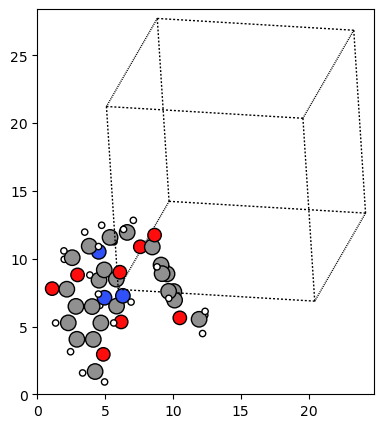

In [157]:
import matplotlib.pyplot as plt
from ase.visualize.plot import plot_atoms

# Create a figure and axis for the plot
fig, ax = plt.subplots(figsize=(6, 5))

# Plot the molecule using ASE's plot_atoms function
plot_atoms(mol, ax, radii=0.75, rotation=('60x, 60y, 60z'))


### Make species

In [158]:
# Extract unique chemical symbols from the molecule
species_list = list(set(mol.get_chemical_symbols()))

# Print the list of unique species
print(species_list)

['O', 'H', 'N', 'C']


### Make formula

In [159]:
# Generate a formula string by extracting and sorting unique chemical symbols
formula_string = ''.join(sorted(set([atom.symbol for atom in mol])))

# Print the molecular formula string
print(formula_string)

CHNO


### Get Experimental UV-vis data

In [160]:
# Extract Y-values starting from index 1 (excluding the first column) at row index 220 of the DataFrame
yvalues = uvvis_data.iloc[66, 1:].to_numpy()

# Display the Y-values as a numpy array
yvalues

array([0.4043139315902422, 0.3622695221828056, 0.3281084395392633,
       0.3027066088556037, 0.2851881049358384, 0.2746770025839793,
       0.2698594140060439, 0.270297376604038, 0.2751149651819735,
       0.2831734769850654, 0.2941663381947181, 0.307611789953138,
       0.3234660360005255, 0.341115928699689, 0.3612184119476196,
       0.3832479306267244, 0.4071168922174046, 0.4326939079402619,
       0.4606359216922874, 0.4900670082774931, 0.520593001357684,
       0.5528708448298515, 0.5861997985372049, 0.6207988437787413,
       0.6561862216966671, 0.6920115622125871, 0.7277055139491088,
       0.7635308544650287, 0.7986116585643586, 0.8323785748697061,
       0.8639863355669426, 0.8932422371129506, 0.9199185389567732,
       0.9435247229886567, 0.96343012306749, 0.9790653878158804,
       0.9906494985328252, 0.9976569001007314, 1.0, 0.9976262427188718,
       0.9893618884947224, 0.9750448911662944, 0.9553365742565584,
       0.930517233828231, 0.9030350808040992, 0.874545613804581

In [162]:
import numpy as np

xvalues = np.arange(220,401,1)

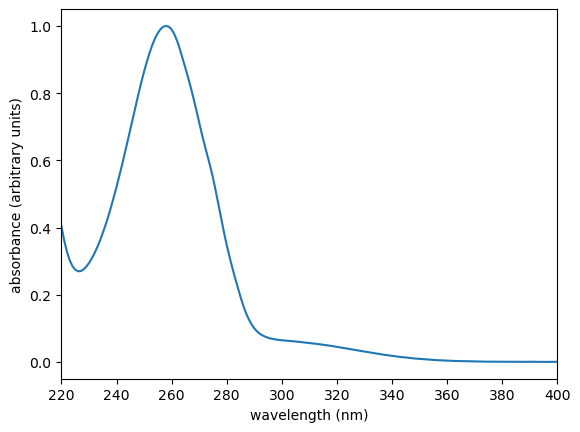

In [163]:
import matplotlib.pyplot as plt

plt.xlabel('wavelength (nm)')
plt.ylabel('absorbance (arbitrary units)')
plt.plot(xvalues,yvalues)
plt.xlim(220,400)
plt.show()

### Downsampling Approaches

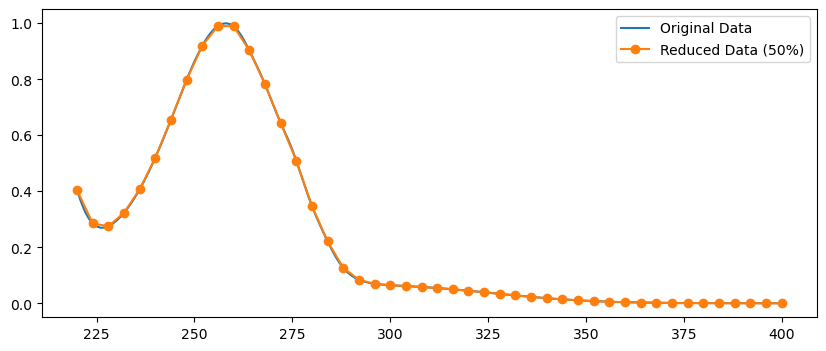

In [164]:
## Simple Subsampling


import matplotlib.pyplot as plt

# Assuming xvalues and yvalues are your original numpy arrays
x_reduced = xvalues[::4]
y_reduced = yvalues[::4]

# Plotting to compare
plt.figure(figsize=(10, 4))
plt.plot(xvalues, yvalues, label='Original Data')
plt.plot(x_reduced, y_reduced, 'o-', label='Reduced Data (50%)')
plt.legend()
plt.show()


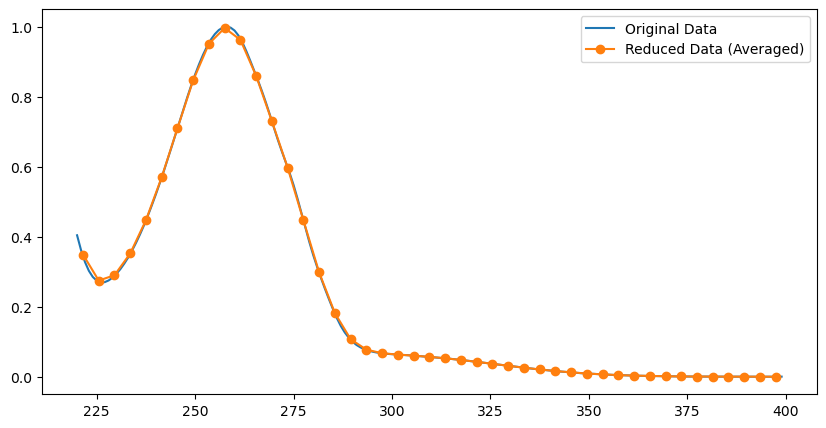

In [165]:
## Averaging Neighboring Points

import matplotlib.pyplot as plt

# Ensure even number of data points
if len(xvalues) % 2 != 0:
    xvalues = xvalues[:-1]
    yvalues = yvalues[:-1]

# Reshape and average
x_reduced = xvalues.reshape(-1, 4).mean(axis=1)
y_reduced = yvalues.reshape(-1, 4).mean(axis=1)

# Plotting to compare
plt.figure(figsize=(10, 5))
plt.plot(xvalues, yvalues, label='Original Data')
plt.plot(x_reduced, y_reduced, 'o-', label='Reduced Data (Averaged)')
plt.legend()
plt.show()


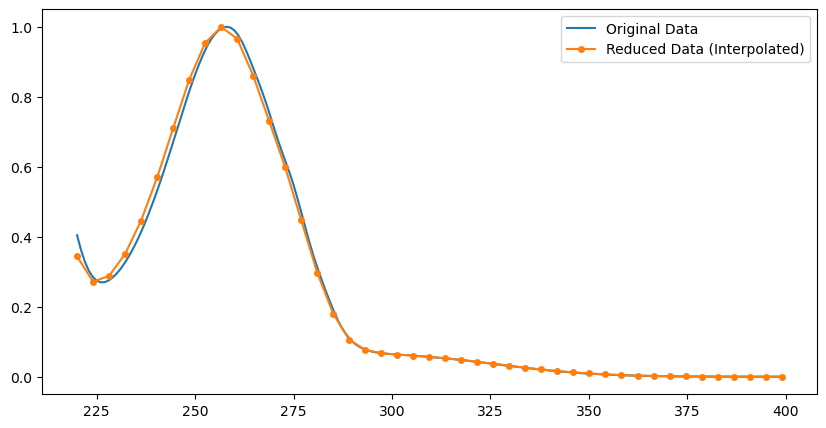

In [167]:
## Resampling Using Interpolation

import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d

# Create an interpolation function
interp_func = interp1d(xvalues, yvalues, kind='cubic')

# Generate new xvalues with 50% fewer points
num_points = len(xvalues) // 4
#print(num_points)
#x_reduced = np.arange(xvalues[0], xvalues[-1]+1, 4)
x_reduced_interp = np.linspace(xvalues[0], xvalues[-1], num_points)
y_reduced_interp = interp_func(x_reduced)
#print(x_reduced)

# Plotting to compare
plt.figure(figsize=(10, 5))
plt.plot(xvalues, yvalues, label='Original Data')
plt.plot(x_reduced_interp, y_reduced_interp, 'o-', label='Reduced Data (Interpolated)', markersize=4)
plt.legend()
plt.show()


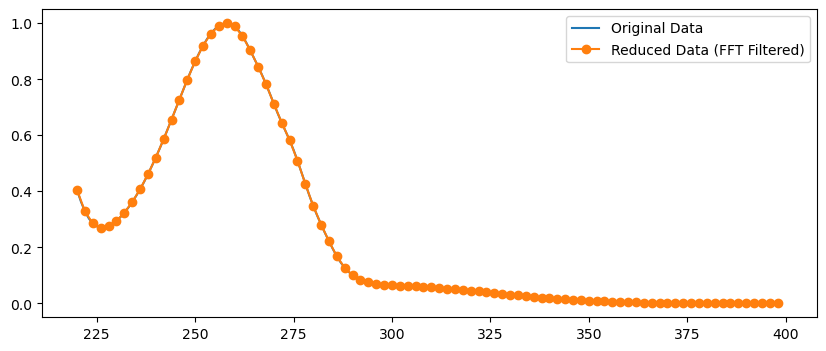

In [171]:
## Downsampling with Fourier Transform

import numpy as np
import matplotlib.pyplot as plt

# Perform FFT
y_fft = np.fft.fft(yvalues)
# Zero out the higher frequencies
#y_fft[int(len(y_fft)/2):] = 0
# Perform inverse FFT
y_filtered = np.fft.ifft(y_fft).real

# Downsample
x_reduced = xvalues[::2]
y_reduced = y_filtered[::2]

# Plotting to compare
plt.figure(figsize=(10, 4))
plt.plot(xvalues, yvalues, label='Original Data')
plt.plot(x_reduced, y_reduced, 'o-', label='Reduced Data (FFT Filtered)')
plt.legend()
plt.show()


In [131]:
## Downsampling simulated data

90


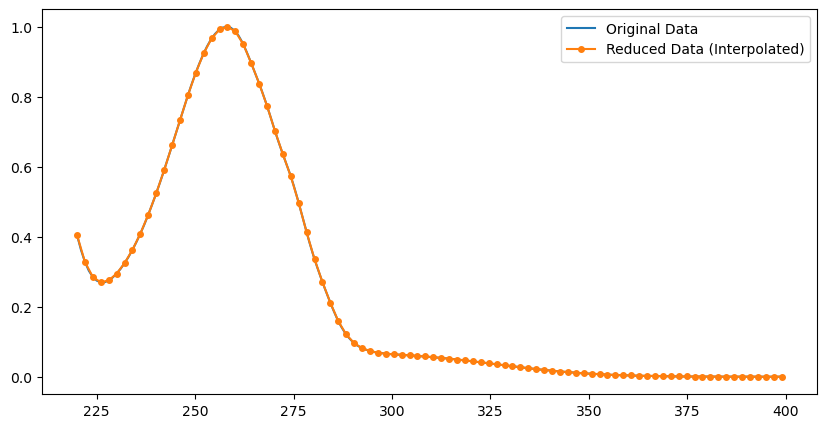

In [172]:
## Resampling Using Interpolation

import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d

# Create an interpolation function
interp_func = interp1d(xvalues, yvalues, kind='cubic')

# Generate new xvalues with 50% fewer points
num_points = len(xvalues) // 2
print(num_points)
#x_reduced = np.arange(xvalues[0], xvalues[-1]+1, 4)
x_reduced_interp = np.linspace(xvalues[0], xvalues[-1], num_points)
y_reduced_interp = interp_func(x_reduced_interp)
#print(x_reduced)

# Plotting to compare
plt.figure(figsize=(10, 5))
plt.plot(xvalues, yvalues, label='Original Data')
plt.plot(x_reduced_interp, y_reduced_interp, 'o-', label='Reduced Data (Interpolated)', markersize=4)
plt.legend()
plt.show()

### Name molecule

In [173]:
import pubchempy

# Extract the SMILES string from the DataFrame at row index 220, column 0
smiles = uvvis_data.iloc[66, 0]

# Fetch compound information from PubChem using the SMILES string
compounds = pubchempy.get_compounds(smiles, namespace='smiles')

# Get the first matching compound
match = compounds[0]

# Print the IUPAC name of the compound
print(match.iupac_name)

name = match.iupac_name

2-[(2,4-dioxo-1H-pyrimidin-5-yl)-[2-(4-methoxybenzoyl)oxyethyl]amino]ethyl 4-methoxybenzoate


### Combine data

In [174]:
mpid = 66

This function is useful for ensuring compatibility with formats that do not support numpy arrays directly, such as JSON or certain databases.

In [175]:
def atoms_to_dict(atoms):
    atoms_dict = atoms.todict()
    for key in atoms_dict:
        if isinstance(atoms_dict[key], np.ndarray ):
            atoms_dict[key] = [item.tolist() if hasattr(item, 'tolist') else item for item in atoms_dict[key]]
            
    return atoms_dict

#### Dictionary Construction for Material Properties

This code constructs a dictionary row containing various properties of a molecular or material structure. The dictionary includes:

- mp_id: The material project ID (mpid).
- structure: The structure of the molecule converted to a dictionary format using the atoms_to_dict function.
- name: The name of the molecule or material.
- phfreq: A list of xvalues for UVVis converted from numpy array xvalues to a list.
- phdos: A list of experimental - computational UVVis energies converted from numpy array yvalues to a list.
- pdos: An empty list for partial density of states.
- formula: The molecular formula string (formula_string).
- species: A list of unique chemical species present in the structure (species_list).
- exptfreq: A list of experimental UVVis energies converted from numpy array yvalues to a list.
- compfreq: A list of computational UVVis energies converted from numpy array yvalues to a list.

Finally, the constructed dictionary row is printed.

In [136]:
yexpt_reduced_interp = y_reduced_interp.copy()
ycomp_reduced_interp = y_reduced_interp.copy()

In [137]:
row = {'mp_id': mpid, 
        'structure': atoms_to_dict(mol), 
        'name': name,
        'phfreq': x_reduced_interp.tolist(), 
        'phdos': y_reduced_interp.tolist(),
        'pdos':[],
        'formula': formula_string,
        'species': species_list,
        'expt': yexpt_reduced_interp.tolist(),
        'comp': ycomp_reduced_interp.tolist()}
print(row)

{'mp_id': 66, 'structure': {'numbers': [6, 8, 6, 6, 6, 6, 6, 6, 6, 8, 8, 6, 6, 7, 6, 6, 8, 6, 8, 6, 6, 6, 6, 8, 6, 6, 6, 6, 6, 7, 6, 8, 7, 6, 8, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], 'positions': [[0.814549607778, 5.053386810043, 3.61135386429], [0.441049607778, 3.775846810043, 3.09854386429], [0.894419607778, 3.622026810043, 1.81796386429], [0.003709607778, 3.821996810043, 0.76597386429], [0.417739607778, 3.570466810043, -0.54180613571], [1.707919607778, 3.079686810043, -0.78588613571], [2.600039607778, 2.883056810043, 0.27541386429], [2.188339607778, 3.154926810043, 1.58316386429], [2.046159607778, 2.685166810043, -2.17214613571], [1.728629607778, 3.326666810043, -3.16043613571], [2.622379607778, 1.455086810043, -2.15351613571], [2.603649607778, 0.781736810043, -3.42417613571], [2.730389607778, -0.740173189957, -3.23235613571], [1.525819607778, -1.389533189957, -2.64370613571], [0.350119607778, -1.456973189957, -3.55491613571], [-0.630190392222, 

### Putting it all Together
OK. Now that we have that we can apply it to every molecule in the UV-vis dataset. The following cells will help us do that. First let's reload import all libraries again.

In [138]:
import pandas as pd
import numpy as np
import pubchempy 
import psi4
from ase import Atoms
import ase.io
from tempfile import NamedTemporaryFile

from ase import Atoms
from ase.optimize import BFGS
from ase.calculators.mopac import MOPAC

from openbabel import pybel


Now let's load the data from the CSV file to a pandas dataframe

In [139]:
uvvis_df = pd.read_csv("UV_w_SMILES.csv",header=None)
uvvis_df.head()

,0,1,2,3,4,5,6,7,8,9,...,172,173,174,175,176,177,178,179,180,181
0,NC1=NC2=C(C=CC=C2)[N+]([O-])=N1,0.299539,0.311787,0.328491,0.349915,0.376548,0.408694,0.446354,0.489792,0.537421,...,0.092434,0.095006,0.097484,0.099952,0.102239,0.104428,0.106597,0.108721,0.110758,0.112611
1,NC1=NC2=C(C=CC=C2)N=N1,0.411922,0.447550,0.487158,0.530422,0.576958,0.626523,0.678088,0.731087,0.783621,...,0.094415,0.095031,0.095445,0.095832,0.095950,0.095919,0.095820,0.095594,0.095204,0.094772
2,CCC1=[N+]([O-])C2=C(C=CC=C2)[N+]([O-])=N1,0.732482,0.794217,0.853497,0.907398,0.952023,0.983787,1.000000,0.998714,0.982111,...,0.398864,0.409874,0.420358,0.429326,0.437889,0.445579,0.452843,0.459056,0.464107,0.468328
3,CN(C)CC1=CNC2=CC=C(C=C12)[N+]([O-])=O,0.412611,0.399813,0.390055,0.382307,0.376957,0.373062,0.371521,0.370622,0.371992,...,0.033980,0.029478,0.024774,0.020789,0.017146,0.013311,0.009733,0.006266,0.003120,0.000000
4,NC(=N)SCCN1C(=O)C2=CC=CC=C2C1=O,0.991241,1.000000,0.996943,0.979253,0.944010,0.890630,0.820660,0.739217,0.655266,...,0.000543,0.000694,0.000529,0.000495,0.000374,0.000433,0.000577,0.000560,0.000574,0.000412


In [140]:
def atoms_to_dict(atoms):
    atoms_dict = atoms.todict()
    for key in atoms_dict:
        if isinstance(atoms_dict[key], np.ndarray ):
            atoms_dict[key] = [item.tolist() if hasattr(item, 'tolist') else item for item in atoms_dict[key]]
            
    return atoms_dict

In [141]:
from openbabel import pybel

# Function to convert SMILES to XYZ
def smiles_to_xyz(smiles_string):
    # Convert SMILES to molecule
    mol = pybel.readstring("smi", smiles_string)
    
    # Add hydrogens
    mol.addh()
    
    # Generate 3D coordinates
    mol.make3D()
    
    # Optimize geometry
    mol.localopt()
    
    # Get XYZ coordinates
    xyz = mol.write("xyz")

    return xyz

In [142]:
# Set Psi4 options
psi4.set_memory('500 MB')
psi4.set_num_threads(1)
psi4.core.be_quiet()


molecule = psi4.geometry(coordinates)


The following cell initializes an empty DataFrame with columns to store UV-Vis data and associated molecular information. The script defines the X-values for the UV-Vis spectrum.

The main part of the script iterates through each row in the uvvis_df DataFrame. For each SMILES string in the DataFrame, the script converts the SMILES to XYZ coordinates and fetches the compound name from PubChem. Using Psi4, it defines the molecular geometry and creates a temporary XYZ file for ASE to read the molecule's structure.

After reading the XYZ file, the script sets the cell dimensions and periodic boundary conditions. It then extracts the unique chemical species and formula, as well as Y-values from the DataFrame row. A dictionary is created for the new row, containing all relevant data, and this dictionary is appended to the DataFrame.


In [143]:
# Initialize the DataFrame
df = pd.DataFrame(columns=['uvvis_id', 'structure', 'name', 'phfreq', 'phdos', 'pdos', 'formula', 'species', 'smiles','expt','comp'])

# X-values for UV-Vis
xvalues = np.arange(220, 401, 1)

# Iterate through each row in the uvvis_df DataFrame
for index, row in uvvis_df.iterrows():
    
    smiles = row[0]

    # Get XYZ coordinates from SMILES
    xyz0 = smiles_to_xyz(smiles)

    # Get compound name from PubChem
    compounds = pubchempy.get_compounds(smiles, namespace='smiles')
    name = compounds[0].iupac_name

    # Define the molecule using Psi4
    molo = psi4.geometry(coordinates)
    #molo = optimize_with_psi4(xyz0, 0)

    # Define the molecule using ASE
    #molo = optimize_with_ase(xyz0)

    temp_filename = xyz0
    temp_filename = molo
    # Create a temporary XYZ file for ASE
    with NamedTemporaryFile(delete=False, suffix=".xyz") as file:
        molo.save_xyz_file(file.name, 1)
        temp_filename = file.name

    # Read the molecule from the XYZ file
    mol = ase.io.read(temp_filename)
    mol.set_cell((25.0, 25.0, 25.0))
    mol.set_pbc((True, True, True))

    # Extract species and formula
    species_list = list(set(mol.get_chemical_symbols()))
    formula_string = ''.join(sorted(set([atom.symbol for atom in mol])))

    # Extract Y-values from the row
    yvalues = row[1:].to_numpy()
    
    # Create an interpolation function
    interp_func = interp1d(xvalues, yvalues, kind='cubic')

    # Generate new xvalues with 75% fewer points
    x_reduced = np.arange(xvalues[0], xvalues[-1]+1, 4)
    y_reduced = interp_func(x_reduced)

    # Create a dictionary for the new row
    panda_row = {
        'uvvis_id': index,
        'structure': atoms_to_dict(mol),
        'name': name,
        'phfreq': x_reduced.tolist(),
        'phdos': y_reduced.tolist(),
        'pdos': [],
        'formula': formula_string,
        'species': species_list,
        'smiles': smiles,
        'expt': y_reduced.tolist(),
        'comp': y_reduced.tolist()
    }

    # Append the new row to the DataFrame
    new_data = pd.DataFrame([panda_row])
    df = pd.concat([df, new_data], ignore_index=True)


# Display the DataFrame
#print(df.head())


*** Open Babel Warning  in CorrectStereoAtoms
  Could not correct 1 stereocenter(s) in this molecule ()
  with Atom Ids as follows: 13


Let's check out the top of the database (the first five molecule entries) to see that everything worked as expected.

In [136]:

df.head()

,uvvis_id,structure,name,phfreq,phdos,pdos,formula,species,smiles
0,0,"{'numbers': [7, 6, 7, 6, 6, 6, 6, 6, 6, 7, 8, ...","1-oxido-1,2,4-benzotriazin-1-ium-3-amine","[220.0, 224.0909090909091, 228.1818181818182, ...","[0.2995391705069124, 0.3765475427513453, 0.537...",[],CHNO,"[H, C, N, O]",NC1=NC2=C(C=CC=C2)[N+]([O-])=N1
1,1,"{'numbers': [7, 6, 7, 6, 6, 6, 6, 6, 6, 7, 7, ...","1,2,4-benzotriazin-3-amine","[220.0, 224.0909090909091, 228.1818181818182, ...","[0.4119215356773526, 0.5769575685108583, 0.783...",[],CHN,"[H, C, N]",NC1=NC2=C(C=CC=C2)N=N1
2,2,"{'numbers': [6, 6, 6, 7, 8, 6, 6, 6, 6, 6, 6, ...","3-ethyl-1-oxido-1,2,4-benzotriazin-4-ium 4-oxide","[220.0, 224.0909090909091, 228.1818181818182, ...","[0.7324821401428788, 0.9520229479189808, 0.982...",[],CHNO,"[H, C, N, O]",CCC1=[N+]([O-])C2=C(C=CC=C2)[N+]([O-])=N1
3,3,"{'numbers': [6, 7, 6, 6, 6, 6, 7, 6, 6, 6, 6, ...","N,N-dimethyl-1-(5-nitro-1H-indol-3-yl)methanamine","[220.0, 224.0909090909091, 228.1818181818182, ...","[0.4126111781675612, 0.3769571209669825, 0.371...",[],CHNO,"[H, C, N, O]",CN(C)CC1=CNC2=CC=C(C=C12)[N+]([O-])=O
4,4,"{'numbers': [7, 6, 7, 16, 6, 6, 7, 6, 8, 6, 6,...","2-(1,3-dioxoisoindol-2-yl)ethyl carbamimidothi...","[220.0, 224.0909090909091, 228.1818181818182, ...","[0.991240815737678, 0.9440099202055489, 0.6552...",[],CHNOS,"[S, C, O, H, N]",NC(=N)SCCN1C(=O)C2=CC=CC=C2C1=O


Finally we can save the data to a csv file so that it can be read by our machine learning algorithm. 

In [137]:
df.to_csv('uvvis_to_downsample.csv', index=False)

Great! That's it. You're finished.